In [2]:
%load_ext autoreload
%autoreload 2


from ff_energy.ffe.slurm import SlurmJobHandler
from pathlib import Path
import pandas as pd
import jax.numpy as jnp
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import patchworklib as pw


from ff_energy.ffe.potential import (
    LJ,
    DE,
)

from ff_energy.ffe.ff import FF
from ff_energy.ffe.constants import FFEPATH
from ff_energy.plotting.ffe_plots import plot_energy_MSE, plot_ff_fit

from ff_energy.plotting.plotting import set_style, patchwork_grid, save_fig


from ff_energy.plotting.fit_results import residuals_plot, residuals_from_keys
from ff_energy.logs.logging import hide_logs

from ff_energy.ffe.potential import LJ, LJ_bound, DE

from ff_energy.ffe.bonded_terms import FitBondedDCM, FitBonded

hide_logs()


import scienceplots
set_style(no_latex=True)

# sns.set_style()
# plt.style.use(["science", "no-latex"])


from ff_energy.ffe.ff_fit import (
    load_ff,
    fit_func,
    fit_repeat,
)

from ff_energy.utils.ffe_utils import pickle_output, read_from_pickle, str2int, PKL_PATH
from ff_energy.utils.json_utils import load_json

from ff_energy.ffe.structure import atom_key_pairs


WATEREOPT = -76.359922443809
DCMEOPT = -959.371619446202


structure_data = {
    "dcm": "",
    "water_cluster": PKL_PATH / "20230823_water_clusters.pkl.pkl",
}

0 ('C', 'C')
1 ('C', 'CG331')
2 ('C', 'CL')
3 ('C', 'CLA')
4 ('C', 'H')
5 ('C', 'HGA3')
6 ('C', 'HGP1')
7 ('C', 'HT')
8 ('C', 'OG311')
9 ('C', 'OT')
10 ('C', 'POT')
11 ('CG331', 'CG331')
12 ('CG331', 'CL')
13 ('CG331', 'CLA')
14 ('CG331', 'H')
15 ('CG331', 'HGA3')
16 ('CG331', 'HGP1')
17 ('CG331', 'HT')
18 ('CG331', 'OG311')
19 ('CG331', 'OT')
20 ('CG331', 'POT')
21 ('CL', 'CL')
22 ('CL', 'CLA')
23 ('CL', 'H')
24 ('CL', 'HGA3')
25 ('CL', 'HGP1')
26 ('CL', 'HT')
27 ('CL', 'OG311')
28 ('CL', 'OT')
29 ('CL', 'POT')
30 ('CLA', 'CLA')
31 ('CLA', 'H')
32 ('CLA', 'HGA3')
33 ('CLA', 'HGP1')
34 ('CLA', 'HT')
35 ('CLA', 'OG311')
36 ('CLA', 'OT')
37 ('CLA', 'POT')
38 ('H', 'H')
39 ('H', 'HGA3')
40 ('H', 'HGP1')
41 ('H', 'HT')
42 ('H', 'OG311')
43 ('H', 'OT')
44 ('H', 'POT')
45 ('HGA3', 'HGA3')
46 ('HGA3', 'HGP1')
47 ('HGA3', 'HT')
48 ('HGA3', 'OG311')
49 ('HGA3', 'OT')
50 ('HGA3', 'POT')
51 ('HGP1', 'HGP1')
52 ('HGP1', 'HT')
53 ('HGP1', 'OG311')
54 ('HGP1', 'OT')
55 ('HGP1', 'POT')
56 ('HT', 'HT'

<Figure size 100x100 with 0 Axes>

#  Internal energies

# water

In [2]:
waterdata = next(read_from_pickle(PKL_PATH / "water_cluster_pbe0dz_pc.pkl"))
waterdata

water_cluster /home/boittier/Documents/phd/ff_energy/pickles/water_cluster/pbe0dz/pbe0_dz.pc ['ECOL', 'KEY', 'TOTAL', 'ELEC', 'VDW', 'KEY', 'M_ENERGY', 'KEY', 'n_monomers', 'C_ENERGY', 'n_pairs', 'intE', 'P_intE', 'm_E_tot', 'p_m_E_tot', 'C_ENERGY_kcalmol']

In [3]:
waterdata.prepare_monomers(min_m_E=WATEREOPT)

len(sumpairs) 500
Structure/PDB already already exists, loading from pickle
Structures/PDBs loaded 500 500
test467.xyz 7
test467.xyz 16
test467.xyz 15
test467.xyz 1
test467.xyz 19
test467.xyz 11
test467.xyz 8
test467.xyz 12
test467.xyz 17
test467.xyz 9
test467.xyz 2
test467.xyz 3
test467.xyz 4
test467.xyz 5
test467.xyz 20
test467.xyz 13
test467.xyz 18
test467.xyz 14
test467.xyz 10
test467.xyz 6
test263.xyz 14
test263.xyz 6
test263.xyz 4
test263.xyz 18
test263.xyz 8
test263.xyz 19
test263.xyz 17
test263.xyz 7
test263.xyz 20
test263.xyz 11
test263.xyz 1
test263.xyz 15
test263.xyz 13
test263.xyz 12
test263.xyz 10
test263.xyz 5
test263.xyz 2
test263.xyz 9
test263.xyz 3
test263.xyz 16
test35.xyz 5
test35.xyz 16
test35.xyz 7
test35.xyz 11
test35.xyz 18
test35.xyz 19
test35.xyz 2
test35.xyz 12
test35.xyz 1
test35.xyz 9
test35.xyz 8
test35.xyz 4
test35.xyz 3
test35.xyz 10
test35.xyz 15
test35.xyz 13
test35.xyz 14
test35.xyz 20
test35.xyz 17
test35.xyz 6
test223.xyz 1
test223.xyz 4
test223.xyz 

In [4]:
waterdata.monomers_df["dE"] = waterdata.monomers_df["m_ENERGY"] - WATEREOPT
waterdata.monomers_df["m_ENERGY"].unique

<bound method Series.unique of test467_7    -76.358246
test467_16   -76.358684
test467_15    -76.35916
test467_1    -76.356498
test467_19   -76.358552
                ...    
test66_18    -76.359427
test66_15     -76.35324
test66_20    -76.354519
test66_2     -76.352639
test66_9     -76.357907
Name: m_ENERGY, Length: 10000, dtype: object>

<AxesSubplot:xlabel='a', ylabel='dE'>

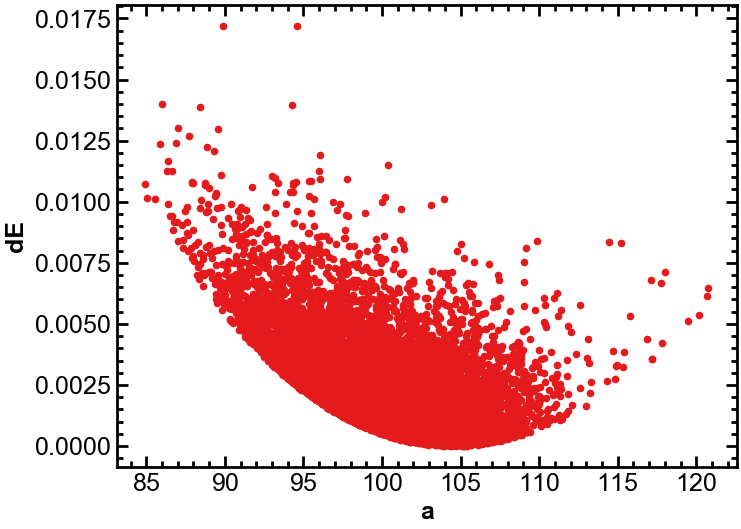

In [5]:
waterdata.monomers_df.plot.scatter("a", "dE")

In [6]:
waterdata.add_internal_dof()

test467.xyz 7
test467.xyz 16
test467.xyz 15
test467.xyz 1
test467.xyz 19
test467.xyz 11
test467.xyz 8
test467.xyz 12
test467.xyz 17
test467.xyz 9
test467.xyz 2
test467.xyz 3
test467.xyz 4
test467.xyz 5
test467.xyz 20
test467.xyz 13
test467.xyz 18
test467.xyz 14
test467.xyz 10
test467.xyz 6
test263.xyz 14
test263.xyz 6
test263.xyz 4
test263.xyz 18
test263.xyz 8
test263.xyz 19
test263.xyz 17
test263.xyz 7
test263.xyz 20
test263.xyz 11
test263.xyz 1
test263.xyz 15
test263.xyz 13
test263.xyz 12
test263.xyz 10
test263.xyz 5
test263.xyz 2
test263.xyz 9
test263.xyz 3
test263.xyz 16
test35.xyz 5
test35.xyz 16
test35.xyz 7
test35.xyz 11
test35.xyz 18
test35.xyz 19
test35.xyz 2
test35.xyz 12
test35.xyz 1
test35.xyz 9
test35.xyz 8
test35.xyz 4
test35.xyz 3
test35.xyz 10
test35.xyz 15
test35.xyz 13
test35.xyz 14
test35.xyz 20
test35.xyz 17
test35.xyz 6
test223.xyz 1
test223.xyz 4
test223.xyz 17
test223.xyz 12
test223.xyz 2
test223.xyz 11
test223.xyz 8
test223.xyz 13
test223.xyz 18
test223.xyz 3
te

In [8]:
bonded.x

NameError: name 'bonded' is not defined

In [9]:
WATEREOPT*20

-1527.19844887618

In [10]:
bonded = waterdata.bonded_fit
loss_df = bonded.get_loss_df(bonded.x)
loss_df["clusterkey"] = loss_df["KEY"].apply(lambda x: x.split("_")[0])
fitted_monomer_energies = loss_df.groupby("clusterkey").sum()["E_pred"]
WATEREOPT*20 + fitted_monomer_energies/627.509 

clusterkey
test0     -1527.135459
test1     -1527.136457
test10    -1527.154128
test100   -1527.144335
test101   -1527.163220
              ...     
test95    -1527.136028
test96    -1527.132675
test97    -1527.152357
test98    -1527.161982
test99    -1527.149274
Name: E_pred, Length: 500, dtype: float64

In [11]:
waterdata.data = waterdata.data.sort_index()
# waterdata.data["m_E_tot"] = waterdata.bonded_fit.sum_monomer_df["m_E_tot"]
# waterdata.data["p_m_E_tot"] = waterdata.bonded_fit.sum_monomer_df["p_m_E_tot"]

waterdata.data["fittedM_ENERGY"] = WATEREOPT*waterdata.data["n_monomers"] + fitted_monomer_energies/627.509 


In [12]:
# waterdata.bonded_fit.sum_monomer_df["m_E_tot"]

In [13]:
waterdata.data#.describe()

,ECOL,KEY,TOTAL,ELEC,VDW,M_ENERGY,n_monomers,C_ENERGY,n_pairs,intE,P_intE,m_E_tot,p_m_E_tot,C_ENERGY_kcalmol,fittedM_ENERGY
test0,-173.022645,test0,24.14023,-86.50353,20.41138,-1527.133263,20,-1527.276175,190,-89.677734,-77.478222,NaN,NaN,-958370.381547,-1527.135459
test1,-105.096240,test1,25.25058,-55.44306,8.97296,-1527.135387,20,-1527.221635,189,-54.121080,-53.285800,NaN,NaN,-958336.157791,-1527.136457
test10,-108.320600,test10,22.55630,-52.42873,8.46527,-1527.152885,20,-1527.237300,190,-52.970302,-53.686359,NaN,NaN,-958345.987230,-1527.154128
test100,-120.244324,test100,23.76369,-66.03681,19.45476,-1527.141372,20,-1527.210157,190,-43.162995,-42.125801,NaN,NaN,-958328.955198,-1527.144335
test101,-125.221598,test101,19.42966,-67.62729,15.89952,-1527.160675,20,-1527.249770,190,-55.907430,-56.202439,NaN,NaN,-958353.812267,-1527.163220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test95,-123.917572,test95,24.31345,-71.02166,12.12799,-1527.135077,20,-1527.246088,190,-69.659773,-64.474238,NaN,NaN,-958351.502253,-1527.136028
test96,-163.434955,test96,25.18816,-78.76038,18.10955,-1527.131558,20,-1527.246828,190,-72.332202,-71.755372,NaN,NaN,-958351.966386,-1527.132675
test97,-132.990408,test97,22.23548,-71.50784,10.84849,-1527.149964,20,-1527.258582,190,-68.158347,-66.680359,NaN,NaN,-958359.342081,-1527.152357
test98,-114.076388,test98,19.89380,-59.12743,9.63436,-1527.160158,20,-1527.264598,190,-65.536420,-61.124988,NaN,NaN,-958363.117026,-1527.161982


In [14]:
waterdata.data["MMintE"] = 627.509 * (waterdata.data["C_ENERGY"] - waterdata.data["fittedM_ENERGY"] )

array([[<AxesSubplot:title={'center':'intE'}>,
        <AxesSubplot:title={'center':'MMintE'}>]], dtype=object)

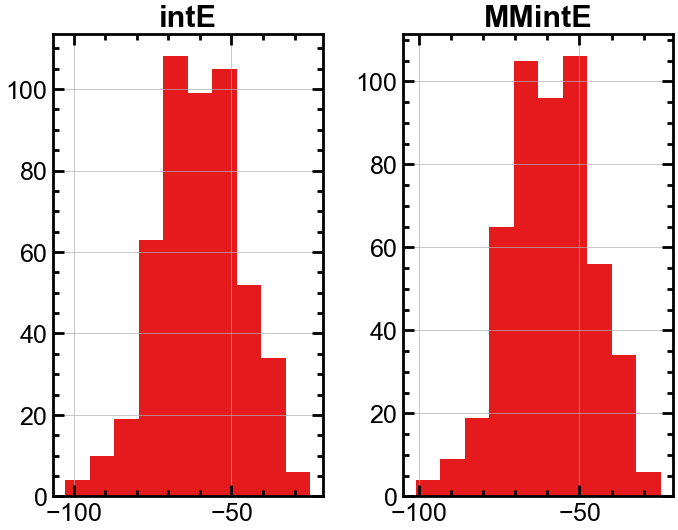

In [15]:
# waterdata.data["MMintE"].hist()
# waterdata.data["intE"].hist()
waterdata.data.hist(["intE", "MMintE"])

In [16]:
water_pickle =  PKL_PATH / "20230823_water_clusters.pkl.pkl"
water_data = next(read_from_pickle(water_pickle))
water_data

,ECOL,KEY,TOTAL,ELEC,VDW,KEY,M_ENERGY,KEY,n_monomers,C_ENERGY,...,ELECci,ELECp,ELECm,ELECk,ELECnull,ELECppol,ELECmpol,ELECkpol,ELECnullpol,MMintE
test0,-173.022645,test0,24.14023,-86.50353,20.41138,test0,-1527.133263,test0,20,-1527.276175,...,-173.022645,-86.50353,-109.15129,-104.54998,-0.0,-102.879193,-125.526953,-120.925643,-16.375663,-88.300590
test1,-105.096240,test1,25.25058,-55.44306,8.97296,test1,-1527.135387,test1,20,-1527.221635,...,-105.096240,-55.44306,-67.34370,-63.45565,-0.0,-63.017501,-74.918141,-71.030091,-7.574441,-53.449942
test10,-108.320600,test10,22.55630,-52.42873,8.46527,test10,-1527.152885,test10,20,-1527.237300,...,-108.320600,-52.42873,-62.11265,-62.96512,-0.0,-60.745846,-70.429766,-71.282236,-8.317116,-52.191086
test100,-120.244324,test100,23.76369,-66.03681,19.45476,test100,-1527.141372,test100,20,-1527.210157,...,-120.244324,-66.03681,-72.15766,-66.67887,-0.0,-74.372871,-80.493721,-75.014931,-8.336061,-41.303901
test101,-125.221598,test101,19.42966,-67.62729,15.89952,test101,-1527.160675,test101,20,-1527.249770,...,-125.221598,-67.62729,-77.04152,-74.99933,-0.0,-75.897445,-85.311675,-83.269485,-8.270155,-54.310755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test95,-123.917572,test95,24.31345,-71.02166,12.12799,test95,-1527.135077,test95,20,-1527.246088,...,-123.917572,-71.02166,-83.76700,-76.31560,-0.0,-82.682985,-95.428325,-87.976925,-11.661325,-69.064240
test96,-163.434955,test96,25.18816,-78.76038,18.10955,test96,-1527.131558,test96,20,-1527.246828,...,-163.434955,-78.76038,-97.21214,-93.72871,-0.0,-93.362538,-111.814298,-108.330868,-14.602158,-71.632376
test97,-132.990408,test97,22.23548,-71.50784,10.84849,test97,-1527.149964,test97,20,-1527.258582,...,-132.990408,-71.50784,-82.54423,-79.19230,-0.0,-83.690078,-94.726468,-91.374538,-12.182238,-66.657230
test98,-114.076388,test98,19.89380,-59.12743,9.63436,test98,-1527.160158,test98,20,-1527.264598,...,-114.076388,-59.12743,-74.18664,-73.12057,-0.0,-68.149171,-83.208381,-82.142311,-9.021741,-64.392756


In [17]:
water_data["MMintE"] = waterdata.data["MMintE"]
water_data

,ECOL,KEY,TOTAL,ELEC,VDW,KEY,M_ENERGY,KEY,n_monomers,C_ENERGY,...,ELECci,ELECp,ELECm,ELECk,ELECnull,ELECppol,ELECmpol,ELECkpol,ELECnullpol,MMintE
test0,-173.022645,test0,24.14023,-86.50353,20.41138,test0,-1527.133263,test0,20,-1527.276175,...,-173.022645,-86.50353,-109.15129,-104.54998,-0.0,-102.879193,-125.526953,-120.925643,-16.375663,-88.300590
test1,-105.096240,test1,25.25058,-55.44306,8.97296,test1,-1527.135387,test1,20,-1527.221635,...,-105.096240,-55.44306,-67.34370,-63.45565,-0.0,-63.017501,-74.918141,-71.030091,-7.574441,-53.449942
test10,-108.320600,test10,22.55630,-52.42873,8.46527,test10,-1527.152885,test10,20,-1527.237300,...,-108.320600,-52.42873,-62.11265,-62.96512,-0.0,-60.745846,-70.429766,-71.282236,-8.317116,-52.191086
test100,-120.244324,test100,23.76369,-66.03681,19.45476,test100,-1527.141372,test100,20,-1527.210157,...,-120.244324,-66.03681,-72.15766,-66.67887,-0.0,-74.372871,-80.493721,-75.014931,-8.336061,-41.303901
test101,-125.221598,test101,19.42966,-67.62729,15.89952,test101,-1527.160675,test101,20,-1527.249770,...,-125.221598,-67.62729,-77.04152,-74.99933,-0.0,-75.897445,-85.311675,-83.269485,-8.270155,-54.310755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test95,-123.917572,test95,24.31345,-71.02166,12.12799,test95,-1527.135077,test95,20,-1527.246088,...,-123.917572,-71.02166,-83.76700,-76.31560,-0.0,-82.682985,-95.428325,-87.976925,-11.661325,-69.064240
test96,-163.434955,test96,25.18816,-78.76038,18.10955,test96,-1527.131558,test96,20,-1527.246828,...,-163.434955,-78.76038,-97.21214,-93.72871,-0.0,-93.362538,-111.814298,-108.330868,-14.602158,-71.632376
test97,-132.990408,test97,22.23548,-71.50784,10.84849,test97,-1527.149964,test97,20,-1527.258582,...,-132.990408,-71.50784,-82.54423,-79.19230,-0.0,-83.690078,-94.726468,-91.374538,-12.182238,-66.657230
test98,-114.076388,test98,19.89380,-59.12743,9.63436,test98,-1527.160158,test98,20,-1527.264598,...,-114.076388,-59.12743,-74.18664,-73.12057,-0.0,-68.149171,-83.208381,-82.142311,-9.021741,-64.392756


In [192]:
pickle_output(water_data, str(water_pickle)[:-4])

In [180]:
abs(waterdata.data["fittedM_ENERGY"] - waterdata.data["M_ENERGY"]).mean() * 627.509 

1.243107841924045

In [174]:
WATEREOPT*waterdata.data["n_monomers"] - waterdata.data["M_ENERGY"]

test0     -0.065186
test1     -0.063062
test10    -0.045564
test100   -0.057077
test101   -0.037774
             ...   
test95    -0.063371
test96    -0.066891
test97    -0.048485
test98    -0.038291
test99    -0.051081
Length: 500, dtype: float64

[1.04281047e+03 9.74776583e+01 9.63386601e-01 1.82033169e+00]


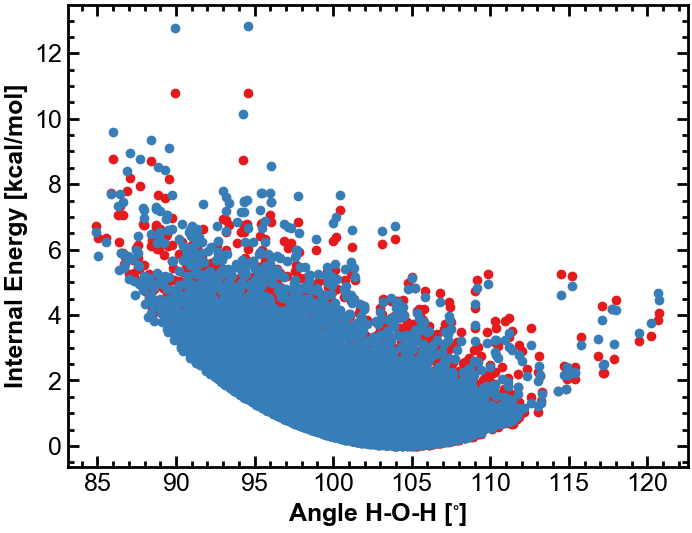

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f86d84fc310>
2023-09-22 18:48:02 | DEBUG | colorbar:_get_ticker_locator_formatter:897 - locator: <matplotlib.ticker.AutoLocator object at 0x7f86d84fc310>


Text(0, 0.5, 'r$_1$ $\\cdot$ r$_2$ [$\\mathrm{\\AA}$]')

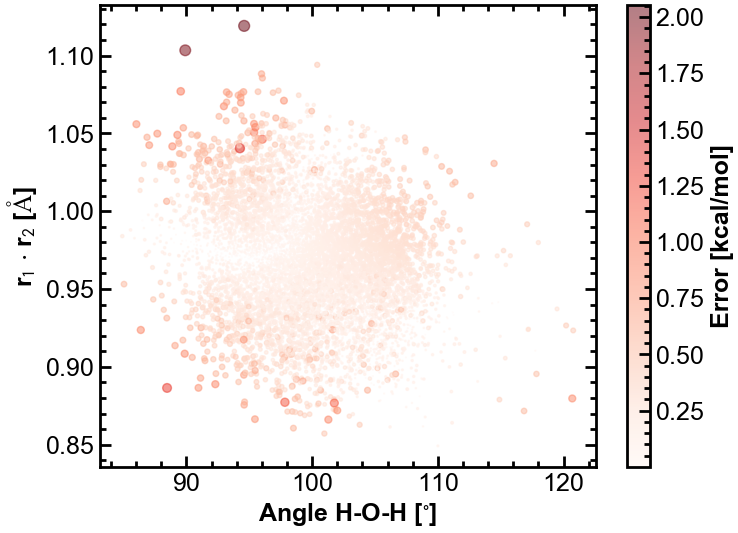

In [106]:
plt.scatter(loss_df["a"], loss_df["m_ENERGY"])
plt.scatter(loss_df["a"], loss_df["E_pred"])
ax = plt.gca()
ax.set_xlabel("Angle H-O-H [$^{\circ}$]")
ax.set_ylabel("Internal Energy [kcal/mol]")

RMSE = np.sqrt(bonded.sum_monomer_df["SE"]).mean()

print(bonded.x)

plt.show()

plt.set_cmap("Reds")

plt.scatter(loss_df["a"], loss_df["r1"] * loss_df["r2"], 
            c=np.sqrt(loss_df["SE"]), 
            s=np.sqrt(loss_df["SE"])*30,
            alpha=0.5)

plt.colorbar(label="Error [kcal/mol]")
ax = plt.gca()

ax.set_xlabel("Angle H-O-H [$^{\circ}$]")
ax.set_ylabel("r$_1$ $\cdot$ r$_2$ [$\mathrm{\AA}$]")

In [101]:
RMSE

3.387020913531974

In [124]:
np.rad2deg(1.8203)

104.29550744766375

In [125]:
waterdata.pairs_df.groupby("key").sum()

,p_ENERGY,p_m1_ENERGY,p_m2_ENERGY,p_int_ENERGY
key,,,,
test0,-29015.655465,-14507.806008,-14507.725985,-0.123471
test1,-28862.942431,-14431.331811,-14431.525702,-0.084918
test10,-29015.990375,-14507.996828,-14507.907991,-0.085556
test100,-29015.753196,-14507.890302,-14507.795761,-0.067133
test101,-29016.142384,-14507.988144,-14508.064675,-0.089566
...,...,...,...,...
test95,-29015.669219,-14507.753474,-14507.812997,-0.102748
test96,-29015.613958,-14507.768208,-14507.731399,-0.114351
test97,-29015.955576,-14507.962968,-14507.886345,-0.106264


In [10]:
waterdata.pairs_df

,p_ENERGY,p_m1_ENERGY,p_m2_ENERGY,p_int_ENERGY,key,pair
test467_4_16,-152.718742,-76.359402,-76.358684,-0.000656,test467,"(4, 16)"
test467_2_12,-152.717266,-76.357394,-76.359906,0.000034,test467,"(2, 12)"
test467_4_5,-152.714677,-76.359402,-76.355286,0.000012,test467,"(4, 5)"
test467_5_16,-152.713801,-76.355286,-76.358684,0.000168,test467,"(5, 16)"
test467_4_20,-152.714093,-76.359402,-76.354903,0.000213,test467,"(4, 20)"
...,...,...,...,...,...,...
test66_3_5,-152.705818,-76.352102,-76.354001,0.000286,test66,"(3, 5)"
test66_2_20,-152.707280,-76.352639,-76.354519,-0.000122,test66,"(2, 20)"
test66_3_10,-152.711822,-76.352102,-76.359671,-0.000049,test66,"(3, 10)"
test66_4_15,-152.712115,-76.358842,-76.353240,-0.000033,test66,"(4, 15)"


In [51]:
waterff = next(read_from_pickle(PKL_PATH / "ELECci_water_cluster_lj_fitted.pkl"))

In [30]:
distsdf = pd.DataFrame(waterff.dists).T
distsdf = distsdf.sort_index()
distsdf

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
test0,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],"[[[4.481767285346262, 3.824425316305706], [5.7...",[],"[[[5.473345320733928], [4.716109625528227]], [...",[],[],"[[[4.6691499226304565]], [[5.540793174266659]]..."
test1,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],"[[[6.2635892266335595, 5.282359037399862], [5....",[],"[[[5.740470625305908], [4.904777466919371]], [...",[],[],"[[[4.808147460301108]], [[2.6928928682738196]]..."
test10,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],"[[[4.670022055622435, 5.993958541731833], [5.2...",[],"[[[4.66432631791559], [6.0320421914970055]], [...",[],[],"[[[5.408158004348616]], [[3.6720121187163857]]..."
test100,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],"[[[5.203678026165723, 5.978657123468446], [4.6...",[],"[[[4.389281604089672], [5.093500662609165]], [...",[],[],"[[[5.205048606881592]], [[5.487645578934558]],..."
test101,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],"[[[4.288065414612982, 5.388273749541684], [4.9...",[],"[[[4.495780021308871], [5.378615900024839]], [...",[],[],"[[[5.389847957039233]], [[4.8753545512095835]]..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test95,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],"[[[4.865469453197708, 6.09312103933608], [4.72...",[],"[[[5.2019843329252735], [6.264010376747471]], ...",[],[],"[[[6.1675224361164664]], [[5.101936299092728]]..."
test96,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],"[[[4.817097673911128, 4.067908307717862], [5.7...",[],"[[[5.6388773705410555], [5.015121733318146]], ...",[],[],"[[[4.973090085650973]], [[5.671985895610108]],..."
test97,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],"[[[4.9049118238761436, 3.998340655822113], [4....",[],"[[[4.210225884676498], [3.4394473393264797]], ...",[],[],"[[[3.8710800818376256]], [[5.182761715533524]]..."
test98,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],"[[[6.497145988816935, 6.899756227577899], [5.0...",[],"[[[5.970403503951806], [6.2592831857969164]], ...",[],[],"[[[6.214812627907619]], [[4.70401743194049]], ..."


In [44]:
median_o_o = [np.median(_) for _ in distsdf[44]]
stdev_o_o = [np.std(_)/2 for _ in distsdf[44]]

In [47]:
# plt.scatter(median_o_o, water_data["ECOL"])
# plt.errorbar(median_o_o, water_data["ECOL"], linestyle="None", xerr=stdev_o_o, alpha=0.5)
# plt.xlim(0,10)

[]

In [63]:
res = pd.DataFrame(waterff.opt_results)
best = res[res["fun"] < 22].sort_values("fun")

(Array([-2.2831789e-07, -5.9128826e-07, -5.3681429e-08, ...,
        -3.4973109e-03, -9.3225809e-04, -1.3224923e-03], dtype=float32),
 Array([0.9871241, 0.9871241, 0.9871241, ..., 4.565531 , 4.565531 ,
        4.565531 ], dtype=float32),
 Array([0.001     , 0.001     , 0.001     , ..., 0.01185686, 0.01185686,
        0.01185686], dtype=float32))

In [ ]:
waterff.eval_jax_flat(best.iloc[0]["x"])

In [98]:
axes = []

for res in range(1):
    test_dists = waterff.debug_df.copy()
    xvals = best.iloc[res]["x"]
    test_dists["test"] = waterff.eval_jax_flat(xvals)[0]

    ax = pw.Brick(figsize=(5,4))
    for i in range(3):
        _2d = test_dists[test_dists["akp"] == i]
        _2d = _2d.sort_values("distances")
        ax.plot(_2d["distances"], _2d["test"], label=i) 
        ax.set_ylim(-1,1)
        ax.set_xlim(0, 8)
        ax.axhline(0, c="k", linewidth=0.1)
        
    # ax.set_title(xvals)

    axes.append(ax)

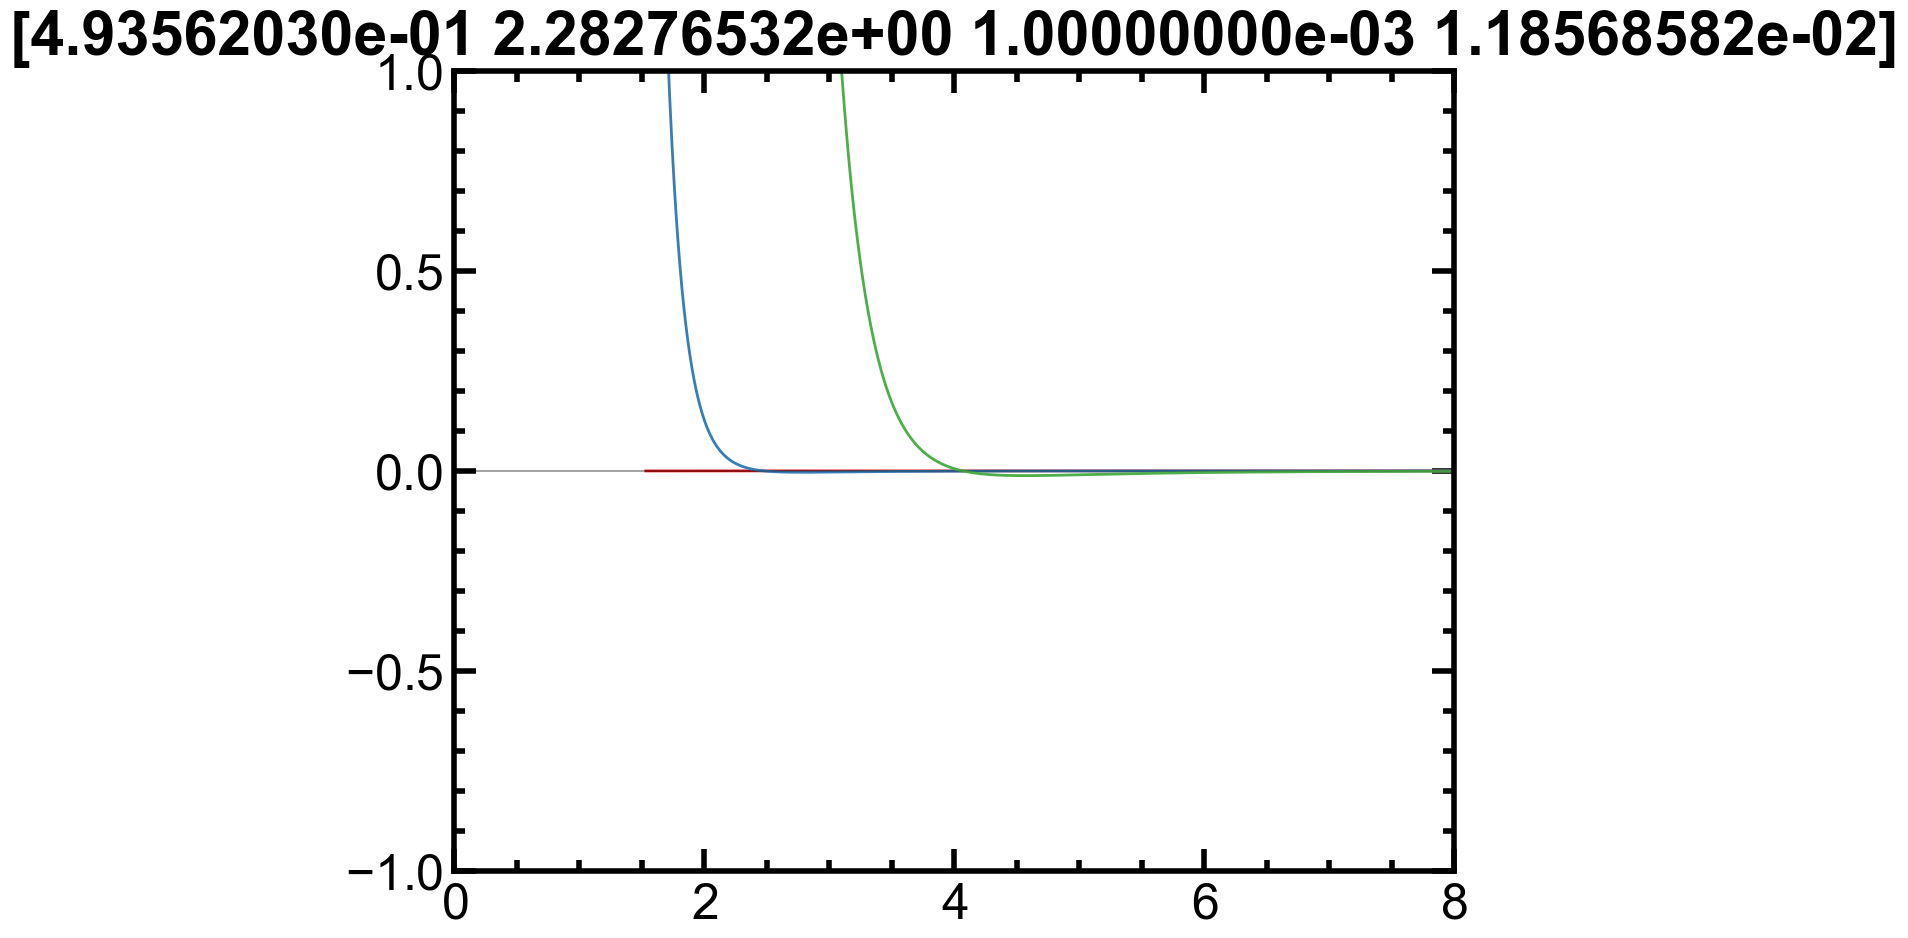

In [99]:
pw.stack(axes, operator="/")

# DCM


In [1]:
dcmdata = next(read_from_pickle(PKL_PATH / "dcm_pbe0dz_pc.pkl"))


NameError: name 'read_from_pickle' is not defined

In [196]:
dcmdata.data.dropna()

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,P_ENERGY,P_intE,intE,C_ENERGY_kcalmol
4,10.17691,-0.52528,-26.36406,100_3502_DCM_408_572,-19187.339166,20.0,-19187.355094,-364559.460580,-12.873639,-9.994774,-1.204012e+07
8,8.71263,-2.83898,-36.23331,100_2276_DCM_266_608,-19187.347217,20.0,-19187.372959,-364559.623591,-11.163915,-16.153728,-1.204013e+07
9,8.28992,-2.25212,-37.26135,100_3572_DCM_416_1180,-19187.348657,20.0,-19187.369654,-364559.645589,-19.687561,-13.175348,-1.204013e+07
11,9.76710,-3.30579,-33.11862,100_3280_DCM_382_1167,-19187.364211,20.0,-19187.393642,-364559.950267,-13.256596,-18.467696,-1.204015e+07
12,10.15151,-2.94845,-34.90538,100_801_DCM_95_801,-19187.350311,20.0,-19187.371620,-364559.677806,-10.305778,-13.371606,-1.204013e+07
...,...,...,...,...,...,...,...,...,...,...,...
190,10.41278,-1.78878,-35.84975,100_98_DCM_12_534,-19187.363529,20.0,-19187.375338,-364559.919025,-17.572315,-7.410277,-1.204014e+07
192,8.85921,-2.39822,-22.76803,100_14_DCM_1_1073,-19187.330486,20.0,-19187.342387,-364559.292428,-11.502464,-7.467863,-1.204011e+07
193,9.11566,-2.49534,-36.11347,100_1292_DCM_151_1088,-19187.357147,20.0,-19187.380367,-364559.810185,-12.170375,-14.570632,-1.204014e+07
196,9.20586,-1.59990,-32.89230,100_3770_DCM_439_744,-19187.355169,20.0,-19187.379049,-364559.773007,-12.681769,-14.984841,-1.204014e+07


In [210]:
dcmdata.monomers_df

,M_ENERGY,KEY,n_monomers,key,monomer
100_3502_DCM_408_572,-19187.337593,100_3502_DCM_408_572,20,572,0
100_2276_DCM_266_608,-19187.358694,100_2276_DCM_266_608,20,608,1
100_3572_DCM_416_1180,-19187.359713,100_3572_DCM_416_1180,20,1180,2
100_3280_DCM_382_1167,-19187.344483,100_3280_DCM_382_1167,20,1167,3
100_801_DCM_95_801,-19187.339166,100_801_DCM_95_801,20,801,4
...,...,...,...,...,...
100_2948_DCM_343_1089,-19187.355169,100_2948_DCM_343_1089,20,1089,196
100_2353_DCM_274_350,-19187.353012,100_2353_DCM_274_350,20,350,197
100_2955_DCM_345_856,-19187.362598,100_2955_DCM_345_856,20,856,198
100_2829_DCM_329_137,-19187.346428,100_2829_DCM_329_137,20,137,199


In [212]:
dcmdata.monomer_df

,m_ENERGY,KEY
100_3502_DCM_408_572_10,-959.369599,100_3502_DCM_408_572_10
100_3502_DCM_408_572_11,-959.363862,100_3502_DCM_408_572_11
100_3502_DCM_408_572_12,-959.370317,100_3502_DCM_408_572_12
100_3502_DCM_408_572_13,-959.367773,100_3502_DCM_408_572_13
100_3502_DCM_408_572_14,-959.368899,100_3502_DCM_408_572_14
...,...,...
100_1987_DCM_232_14_6,-959.369619,100_1987_DCM_232_14_6
100_1987_DCM_232_14_5,-959.369379,100_1987_DCM_232_14_5
100_1987_DCM_232_14_7,-959.367952,100_1987_DCM_232_14_7
100_1987_DCM_232_14_8,-959.365985,100_1987_DCM_232_14_8


In [206]:
s = dcmdata.structure_key_pairs["100_3502_DCM_408_572"]
rm1 = s.res_mask[1]

s.chm_typ[rm1]

array(['C', 'CL', 'CL', 'H', 'H'], dtype='<U2')

In [215]:
dcmdata.add_internal_dof(res="dcm")

('100_3502_DCM_408_572_10', m_ENERGY                -959.369599
KEY         100_3502_DCM_408_572_10
Name: 100_3502_DCM_408_572_10, dtype: object)
100_3502_DCM_408_572 10
100_3502_DCM_408_572 10
('100_3502_DCM_408_572_11', m_ENERGY                -959.363862
KEY         100_3502_DCM_408_572_11
Name: 100_3502_DCM_408_572_11, dtype: object)
100_3502_DCM_408_572 11
100_3502_DCM_408_572 11
('100_3502_DCM_408_572_12', m_ENERGY                -959.370317
KEY         100_3502_DCM_408_572_12
Name: 100_3502_DCM_408_572_12, dtype: object)
100_3502_DCM_408_572 12
100_3502_DCM_408_572 12
('100_3502_DCM_408_572_13', m_ENERGY                -959.367773
KEY         100_3502_DCM_408_572_13
Name: 100_3502_DCM_408_572_13, dtype: object)
100_3502_DCM_408_572 13
100_3502_DCM_408_572 13
('100_3502_DCM_408_572_14', m_ENERGY                -959.368899
KEY         100_3502_DCM_408_572_14
Name: 100_3502_DCM_408_572_14, dtype: object)
100_3502_DCM_408_572 14
100_3502_DCM_408_572 14
('100_3502_DCM_408_572_15', m_

In [220]:
dcmdata.monomer_df["key"] = dcmdata.monomer_df["KEY"].apply(lambda x: "_".join(x.split("_")[:-1]))

In [221]:
dcmdata.monomer_df

,m_ENERGY,KEY,a1,a2,a3,a4,a5,a6,r1,r2,r3,r4,key
100_3502_DCM_408_572_10,-959.369599,100_3502_DCM_408_572_10,108.270663,109.542449,111.260976,108.095825,106.785281,112.707108,1.767222,1.744680,1.100784,1.109835,100_3502_DCM_408_572
100_3502_DCM_408_572_11,-959.363862,100_3502_DCM_408_572_11,113.957130,108.571267,111.202731,106.259421,109.420230,107.084917,1.847901,1.840370,1.050509,1.129464,100_3502_DCM_408_572
100_3502_DCM_408_572_12,-959.370317,100_3502_DCM_408_572_12,111.151316,110.029711,109.848684,104.255212,109.719814,111.736010,1.806839,1.788281,1.095747,1.098385,100_3502_DCM_408_572
100_3502_DCM_408_572_13,-959.367773,100_3502_DCM_408_572_13,108.888751,108.735017,112.288257,108.129798,109.411270,109.296818,1.772832,1.797926,1.072273,1.156541,100_3502_DCM_408_572
100_3502_DCM_408_572_14,-959.368899,100_3502_DCM_408_572_14,107.329034,112.658642,111.440968,103.689660,109.739377,111.584370,1.759192,1.770036,1.105243,1.102420,100_3502_DCM_408_572
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100_1987_DCM_232_14_6,-959.369619,100_1987_DCM_232_14_6,111.047191,107.943059,110.767013,110.880800,109.562855,106.537716,1.740352,1.762657,1.116080,1.114243,100_1987_DCM_232_14
100_1987_DCM_232_14_5,-959.369379,100_1987_DCM_232_14_5,110.377242,110.176676,104.312365,109.525817,107.897437,114.417556,1.835970,1.777089,1.112009,1.104754,100_1987_DCM_232_14
100_1987_DCM_232_14_7,-959.367952,100_1987_DCM_232_14_7,115.612563,105.859148,102.775054,111.249808,110.248141,110.725170,1.838959,1.780534,1.128174,1.111326,100_1987_DCM_232_14
100_1987_DCM_232_14_8,-959.365985,100_1987_DCM_232_14_8,112.571963,107.417908,109.787112,111.101391,106.921716,109.007054,1.832979,1.830423,1.127077,1.140257,100_1987_DCM_232_14


In [218]:
FitBondedDCM(dcmdata.monomer_df, DCMEOPT)

KeyError: 'key'